In [2]:
from lppls import lppls, data_loader
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
%matplotlib inline

ticker = 'PFE'
start = '2019-01-01'
end = '2021-09-01'
data = yf.download([ticker],start,end)
data = data.reset_index()
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')

[*********************100%***********************]  1 of 1 completed


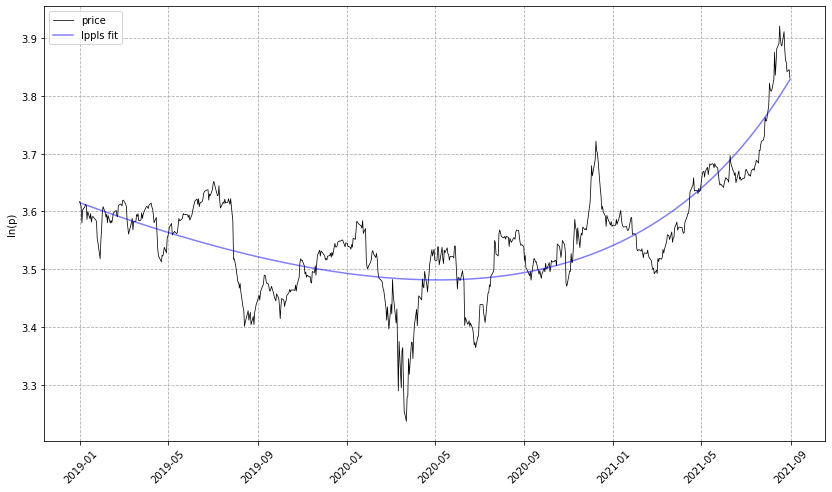

In [205]:
# read example dataset into df 
#data = data_loader.nasdaq_dotcom()
# convert time to ordinal
time = [pd.Timestamp.toordinal(dt.strptime(t1, '%Y-%m-%d')) for t1 in data['Date']]
# create list of observation data
price = np.log(data['Adj Close'].values)
# create observations array (expected format for LPPLS observations)
observations = np.array([time, price])
# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 25
# instantiate a new LPPLS model with the Nasdaq Dot-com bubble dataset
lppls_model = lppls.LPPLS(observations=observations)
# fit the model to the data and get back the params
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)
# visualize the fit
lppls_model.plot_fit()

CPU times: user 402 ms, sys: 152 ms, total: 553 ms
Wall time: 7min 20s


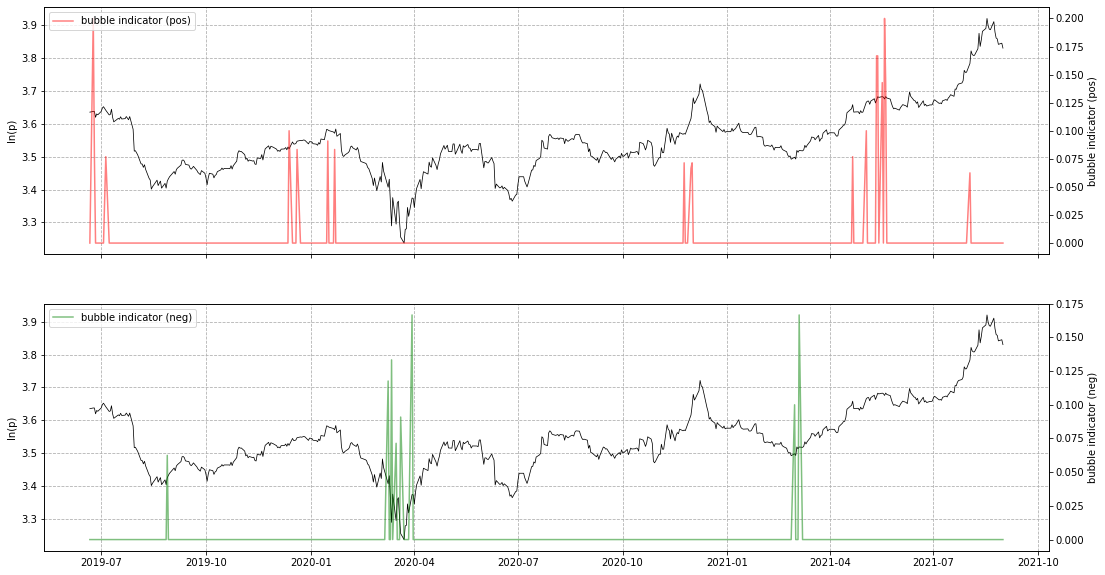

In [206]:
%%time
# compute the confidence indicator
res = lppls_model.mp_compute_nested_fits(
    workers=8,
    window_size=120, 
    smallest_window_size=30, 
    outer_increment=1, 
    inner_increment=5, 
    max_searches=25,
    # filter_conditions_config={} # not implemented in 0.6.x
)
lppls_model.plot_confidence_indicators(res)

In [207]:
res_df = lppls_model.compute_indicators(res)
res_df

,time,price,pos_conf,neg_conf,_fits
0,737231.0,3.635460,0.000000,0.0,"[{'tc': 737231.0000007345, 'm': 1.215713238732..."
1,737234.0,3.637519,0.200000,0.0,"[{'tc': 737234.0000115756, 'm': 0.879207663953..."
2,737235.0,3.637519,0.076923,0.0,"[{'tc': 737235.0000010582, 'm': 0.954626599163..."
3,737236.0,3.619766,0.000000,0.0,"[{'tc': 737236.000000946, 'm': 1.4382305821671..."
4,737237.0,3.629949,0.000000,0.0,"[{'tc': 737237.7222562584, 'm': 1.285017680872..."
...,...,...,...,...,...
549,738027.0,3.860940,0.000000,0.0,"[{'tc': 738058.5641821295, 'm': -0.00182581155..."
550,738028.0,3.858200,0.000000,0.0,"[{'tc': 738062.0465317063, 'm': -0.08211841037..."
551,738029.0,3.841601,0.000000,0.0,"[{'tc': 738058.2750756457, 'm': -0.05711364979..."
552,738032.0,3.845028,0.000000,0.0,"[{'tc': 738063.1406749787, 'm': -0.12576632015..."


In [208]:
df = pd.DataFrame()

In [209]:
ord = res_df['time'].astype('int32')
ts = [pd.Timestamp.fromordinal(d) for d in ord]
df['Date'] = pd.to_datetime(ts, format='%Y%m%d.0')
df['pos_conf'] = res_df['pos_conf']

In [210]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

In [211]:
df3 = pd.merge(df, data, on=["Date"], how="left")

In [212]:
df3['signal'] = np.where(df3['pos_conf'] > 0, 1, 0)
df3['log_returns'] = np.log(df3['Adj Close'] / df3['Adj Close'].shift(1))
df3['strategy_returns'] = df3['log_returns'] * df3['signal'].shift(1)

Buy and hold returns:  0.19
Strategy returns:  0.09


<AxesSubplot:>

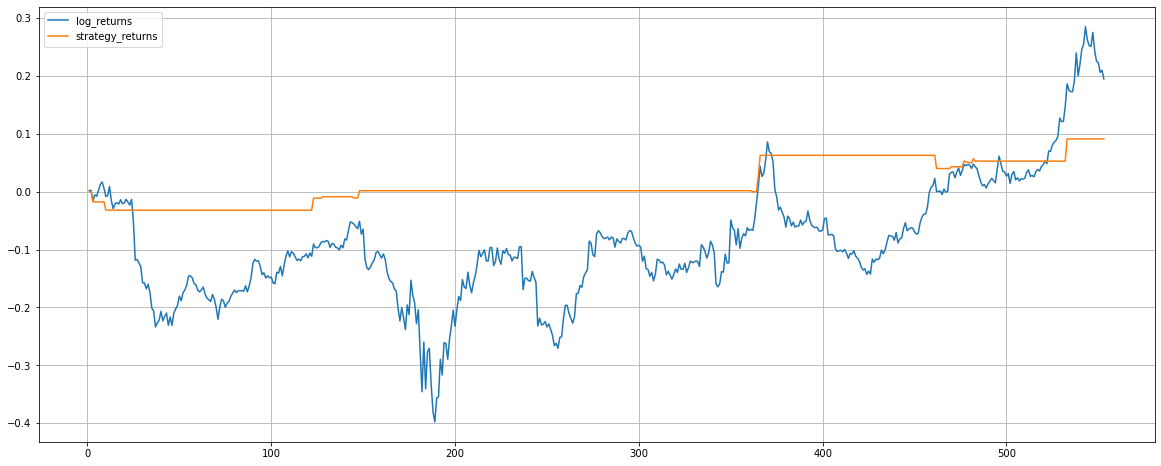

In [213]:
# Calculate and print strategy and BnH returns
print('Buy and hold returns: ', np.round(df3['log_returns'].cumsum().iloc[-1], 2))
print('Strategy returns: ', np.round(df3['strategy_returns'].cumsum().iloc[-1], 2))
# Plot strategy and BnH returns
df3[['log_returns', 'strategy_returns']].cumsum().plot(secondary_y='position', grid=True, figsize=(20, 8))

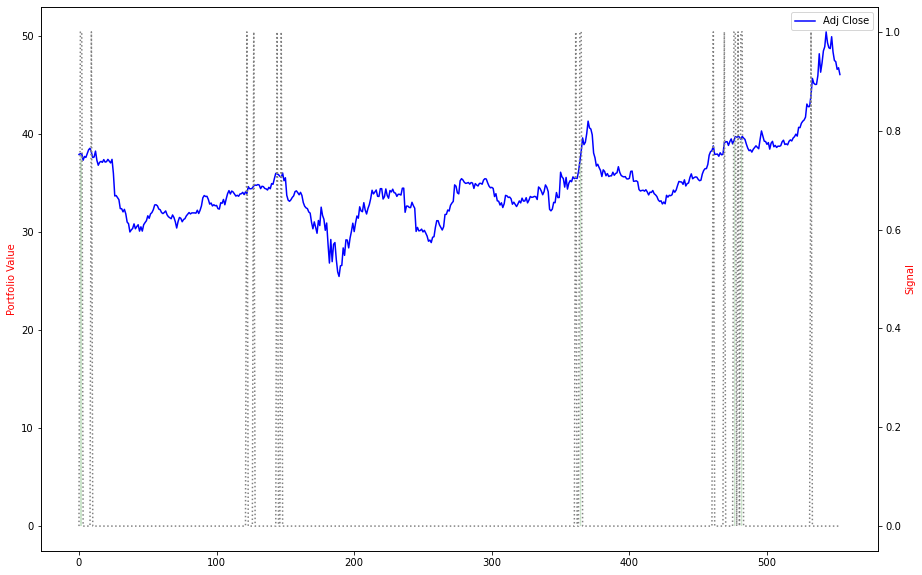

In [214]:
df3['Adj Close'].plot(color='blue')    
plt.fill_between(df3.index, df3['Adj Close'], where=(df3['signal']==1), facecolor='g', alpha=0.2)      
plt.legend()
plt.ylabel('Portfolio Value',color='r')
# Plot the signal values    
df3['signal'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
plt.ylabel('Signal',color='r')
plt.show()

In [218]:
time_ord = [pd.Timestamp.fromordinal(d) for d in lppls_model.observations[0, :].astype('int32')]

In [223]:
lppls_fit = [lppls_model.lppls(t, tc, m, w, a, b, c1, c2) for t in t_obs]
price = lppls_model.observations[1, :]

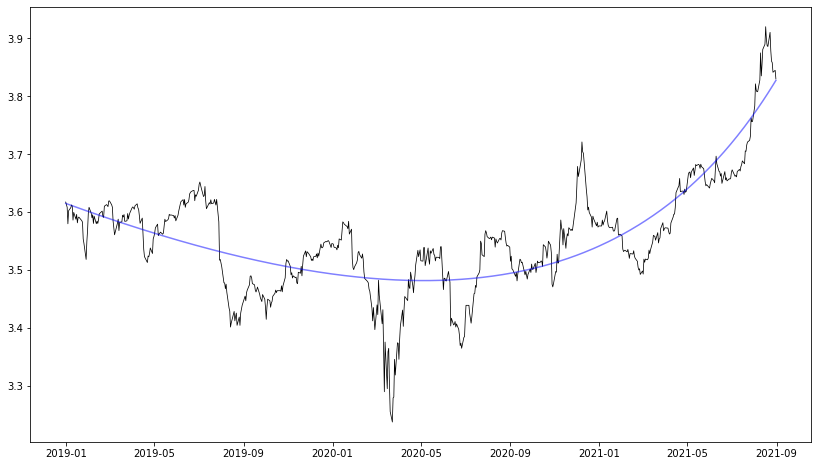

In [290]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(14, 8))
ax1.plot(time_ord, price, label='price', color='black', linewidth=0.75)
ax1.plot(time_ord, lppls_fit, label='lppls fit', color='blue', alpha=0.5)

In [248]:
extremums = pd.Series(lppls_fit).groupby((np.sign(pd.Series(lppls_fit)).diff().fillna(0).ne(0)).cumsum()) \
             .apply(lambda x: x.abs().min() * np.sign(x[x.abs().idxmin()]))

In [249]:
extremums

0    3.481779
dtype: float64

In [291]:
df4 = pd.DataFrame()
df4['lppls'] = lppls_fit
df4['log_price'] = price
df4['Date'] = time_ord

In [293]:
extremums = df4['lppls'].groupby((np.sign(df4['lppls']).diff().fillna(0).ne(0)).cumsum()) \
             .apply(lambda x: x.abs().min() * np.sign(x[x.abs().idxmin()]))
extremums

lppls
0    3.481779
Name: lppls, dtype: float64

In [295]:
for i in range(len(df4['lppls'])):
    if df4['lppls'].iloc[i] == extremums[0]:
        dot = df4.iloc[i]
        print(df4.iloc[i])

lppls                    3.48178
log_price                3.53881
Date         2020-05-05 00:00:00
Name: 338, dtype: object


In [297]:
df4['min']= df4['lppls'].min()

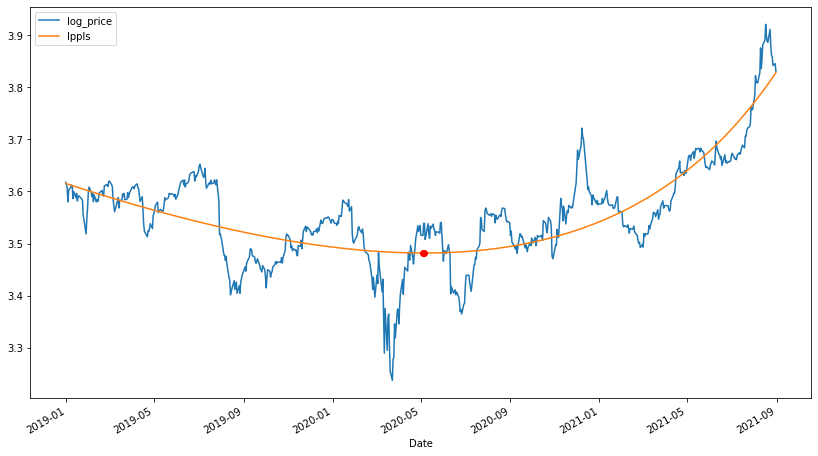

In [302]:
df4.plot(x = 'Date', y = ['log_price', 'lppls'], figsize=(14, 8))
idx = np.argwhere(np.diff(np.sign(df4['lppls'] - df4['min']))).flatten()
plt.plot(df4['Date'][idx], df4['lppls'][idx], 'ro')

### Стратегия LPPLS

In [299]:
ticker = 'NVDA'
start = '2019-01-01'
end = '2021-10-10'
data = yf.download([ticker],start,end)
data = data.reset_index()
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')

[*********************100%***********************]  1 of 1 completed


In [300]:
time = [pd.Timestamp.toordinal(dt.strptime(t1, '%Y-%m-%d')) for t1 in data['Date']]
price = np.log(data['Adj Close'].values)
observations = np.array([time, price])
MAX_SEARCHES = 25
lppls_model = lppls.LPPLS(observations=observations)
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)
#lppls_model.plot_fit()

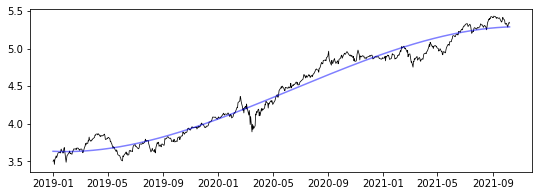

In [301]:
time_ord = [pd.Timestamp.fromordinal(d) for d in lppls_model.observations[0, :].astype('int32')]
t_obs = lppls_model.observations[0, :]
lppls_fit = [lppls_model.lppls(t, tc, m, w, a, b, c1, c2) for t in t_obs]
price = lppls_model.observations[1, :]
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(9, 3))
ax1.plot(time_ord, price, label='price', color='black', linewidth=0.75)
ax1.plot(time_ord, lppls_fit, label='lppls fit', color='blue', alpha=0.5)

In [305]:
df4 = pd.DataFrame()
df4['lppls'] = lppls_fit
df4['log_price'] = price
df4['Date'] = time_ord
df4['log_sma30'] = df4['log_price'].rolling(30).mean()
df4['log_sma100'] = df4['log_price'].rolling(100).mean()

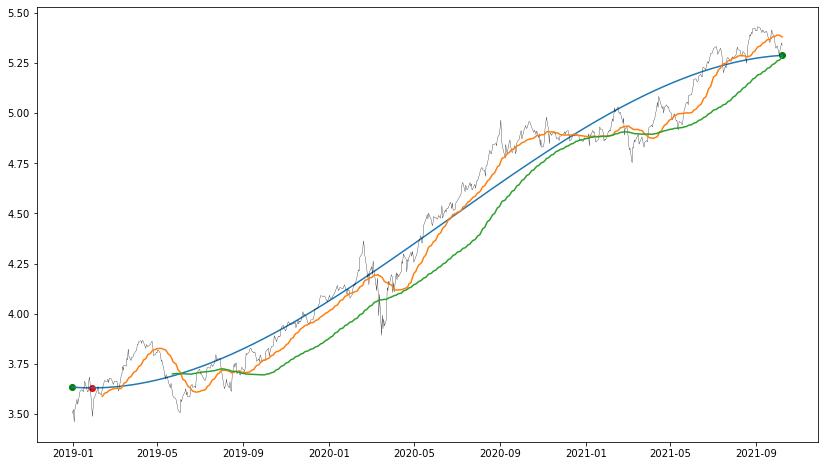

In [306]:
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

n = 5 
df4['min'] = df4.iloc[argrelextrema(df4.lppls.values, np.less_equal,
                    order=n)[0]]['lppls']
df4['max'] = df4.iloc[argrelextrema(df4.lppls.values, np.greater_equal,
                    order=n)[0]]['lppls']

plt.figure(figsize=(14, 8))
plt.scatter(df4['Date'], df4['min'], c='r')
plt.scatter(df4['Date'], df4['max'], c='g')
plt.plot(df4['Date'], df4['lppls'])
plt.plot(df4['Date'], df4['log_price'], color='black', linewidth=0.3)
plt.plot(df4['Date'], df4['log_sma30'])
plt.plot(df4['Date'], df4['log_sma100'])
plt.show()